In [46]:
# Import necessary Libraries
import pandas as pd
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from dateutil.easter import easter
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
sns.set

<function seaborn.rcmod.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)>

In [4]:
# open csv file and load the data into pandas dataframe
df_RawSalesData = pd.read_csv('../data/raw/train.csv', parse_dates=['date'], low_memory=False)
df_RawSalesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null datetime64[ns]
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [5]:
df_RawSalesData.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [6]:
df_RawSalesData.shape

(913000, 4)

In [7]:
df_RawSalesData.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [8]:
df_RawSalesData.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [9]:
df_RawSalesData.sample(5)

,date,store,item,sales
564839,2014-08-29,10,31,79
671354,2016-04-27,8,37,38
729185,2014-09-04,10,40,41
643841,2015-12-26,3,36,68
878446,2013-05-21,2,49,28


In [10]:
df_RawSalesData.count(axis=0, numeric_only=False)

date     913000
store    913000
item     913000
sales    913000
dtype: int64

In [11]:
df_RawSalesData.isnull().any().value_counts() #All 4 columns have no missing values

False    4
dtype: int64

In [12]:
#Outliers
#--------
#Next we will figure out the outliers with The interquartile range (IQR), also called the midspread or middle 50%
#It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.
#IQR is somewhat similar to Z-score in terms of finding the distribution of data and then keeping some threshold to identify the outlier.

Q1 = df_RawSalesData.quantile(0.25)
Q3 = df_RawSalesData.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

store     5.0
item     25.0
sales    40.0
dtype: float64


In [13]:
#After computing the value of IQR, using threshhold of 1.5 * IQR away from Q1 and Q3 on both sides 
df_RawData = df_RawSalesData
df_RawData = df_RawData.drop('date', axis =1)
df_RawSalesDataReduced = df_RawData[~((df_RawData < (Q1 - 1.5 * IQR)) |(df_RawData > (Q3 + 1.5 * IQR))).any(axis=1)]



In [14]:
df_RawSalesDataReduced.shape

(901033, 3)

In [15]:
df_RawSalesData.shape

(913000, 4)

In [16]:
df_SalesData = df_RawSalesData

EDA
-----
#Next we will move on to EDA with individual features

Next, We will inspect each feature individually. We will perform the univariate and bivariate analysis using the folloiwng steps- Summary statistics Plot individually Plot against our target variable- sales. Modify the feature to make it ready for modelling, if necessary
For individual summary statistics we will use 
    .describe()
    .sample(5)
    .nunique()

Finally we will plot the feature against our target feature sales to see if and how both are related

In [44]:
#All the function definitions at one place 

def print_stats(col_name, group_by=False):
    """
    print the general statistics of the passed column
    """
    print('-'*60, '\n Individual Summary Statistics for', col_name, '\n', '-'*60)
    print('Describe \n',df_SalesData[col_name].describe(), '\n', '-'*20)
    print('Sample Observations \n',df_SalesData[col_name].sample(5), '\n', '-'*20)
    print('Number of Uniques \n',df_SalesData[col_name].nunique(), '\n', '-'*20)
    num_uniques = df_SalesData[col_name].nunique()
    if num_uniques <31: 
        print('Unique value counts \n', df_SalesData[col_name].value_counts(), '\n', '-'*20)
        
    if group_by:
        print('Group_by \n', df_SalesData.groupby('sales')[col_name].describe(), '\n','-'*20)
       
def store_analysis(store_num):
    df_store=df_SalesData.loc[df_SalesData['store'] == store_num]
    print(df_store.head())
    print('Top 5 selling items in store', store_num)
    print('-'*30, '\n')
    print(df_store[['sales','item']].groupby(['item']).mean().sort_values(by='sales',ascending=False).head())

    print('\n', 'Bottom 5 selling items in store', store_num )
    print('-'*30, '\n')
    print(df_store[['sales','item']].groupby(['item']).mean().sort_values(by='sales',ascending=False).tail())

    df_store[['sales','item']].groupby(["item"]).mean().sort_values(by='sales',ascending=False).plot.bar(width=0.2, title='store '+ str(store_num) +' item sales')
    plt.show()
    
def monthly_sales(store_num):
    
    for i in range(1, 10):
        df_store=df_SalesData.loc[df_SalesData['store'] == i]
        df_store[['sales','month']].groupby(["month"]).mean().sort_values(by='month',ascending=True).plot.bar(width=0.2, title='store '+ str(i) +' monthly sales')
        plt.show()
    
def plot_var(col_name, full_name, continuous):
    """
    plot a variable with and without sales.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name- for display purposes
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(df_SalesData.loc[df_SalesData[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df_SalesData[col_name], order=sorted(df_SalesData[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of ' + full_name)

    # Plot with sales
    sns.catplot(x= col_name ,y='sales',data=df_SalesData,hue='store',kind='bar', ax=ax2)
    ax2.set_xlabel(full_name)
    ax2.set_ylabel('Sales')
    ax2.set_title(full_name + ' wise sales')
    plt.tight_layout()

def decomp_plot(df):
    decomposition = seasonal_decompose(df)
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(411)
    ax.plot(df, label='Original', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(412)
    ax.plot(decomposition.trend, label='Trend', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(413)
    ax.plot(decomposition.seasonal,label='Seasonality', color = 'b')
    ax.legend(loc='best')
    ax= fig.add_subplot(414)
    ax.plot(decomposition.resid, label='Residuals', color = 'b')
    ax.legend(loc='best')
    plt.show()
    
def naive_forecast(df,coldate,colval,split):
    #print(split)
    import math
    global y_hat, train, test
    total_size=len(df)
    train_size=math.floor(split*total_size) #(split size)
    train=df.head(train_size)
    test=df.tail(len(df) -train_size)
    dd = np.asarray(train[colval])
    lastvalue = dd[len(dd)-1]
    y_hat = test.copy()
    y_hat['naive'] = lastvalue
    print(train.shape, test.shape, y_hat.shape)
    #return y_hat, train, test
    
    print(train.tail())
    print(test.head())
    plt.figure(figsize=(8,8))
    plt.plot(train.index, train[colval], label='Train')
    plt.plot(test.index, test[colval], label='Test')
    plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
    plt.ylabel = 'sales'
    plt.legend(loc='best')
    plt.title("Naive Forecast")
    plt.show()
    rms = sqrt(mean_squared_error(test[colval], y_hat.naive))
    print('\n RMSE for Naive Forecast = '+str(rms))    


1. Store

In [18]:
print_stats('store')

------------------------------------------------------------ 
 Individual Summary Statistics for store 
 ------------------------------------------------------------
Describe 
 count    913000.000000
mean          5.500000
std           2.872283
min           1.000000
25%           3.000000
50%           5.500000
75%           8.000000
max          10.000000
Name: store, dtype: float64 
 --------------------
Sample Observations 
 68365     8
195901    8
429894    6
770271    2
798293    8
Name: store, dtype: int64 
 --------------------
Number of Uniques 
 10 
 --------------------
Unique value counts 
 10    91300
9     91300
8     91300
7     91300
6     91300
5     91300
4     91300
3     91300
2     91300
1     91300
Name: store, dtype: int64 
 --------------------


Looks like there are 10 stores in our dataset. Each store has 91300 individual sales recorded in the dataset.
The column has no missing values and no special characters etc in the data values. The values are 1-10. 
So we will not need to do any pre-processing. 
Let's move onto plotting the graphs!

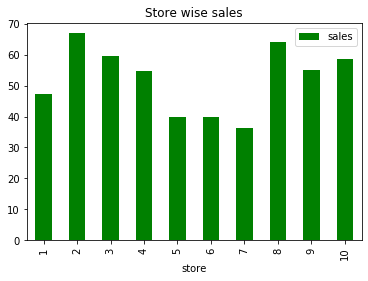

In [19]:
df_SalesData[['sales','store']].groupby(["store"]).mean().plot.bar(color='g', title='Store wise sales')
plt.show()

From the above we see that
1. Store 2 and 8 have high highest sales
2. Store 5 and 7 have lowest sales

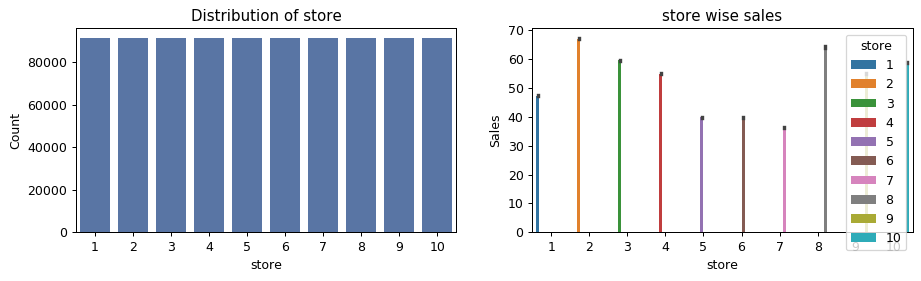

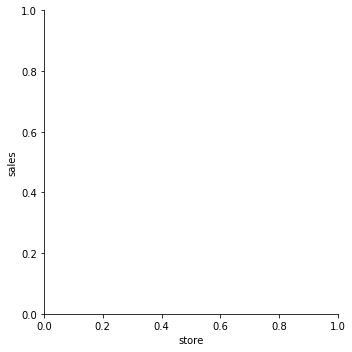

In [20]:
plot_var('store', 'store', False)

In [21]:
df_SalesData.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [22]:
#let's plit the date for easier handling later
df_SalesData['day'] = df_SalesData.date.dt.day
df_SalesData['month'] = df_SalesData.date.dt.month
df_SalesData['year'] = df_SalesData.date.dt.year
df_SalesData['dayofweek'] = df_SalesData.date.dt.dayofweek

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



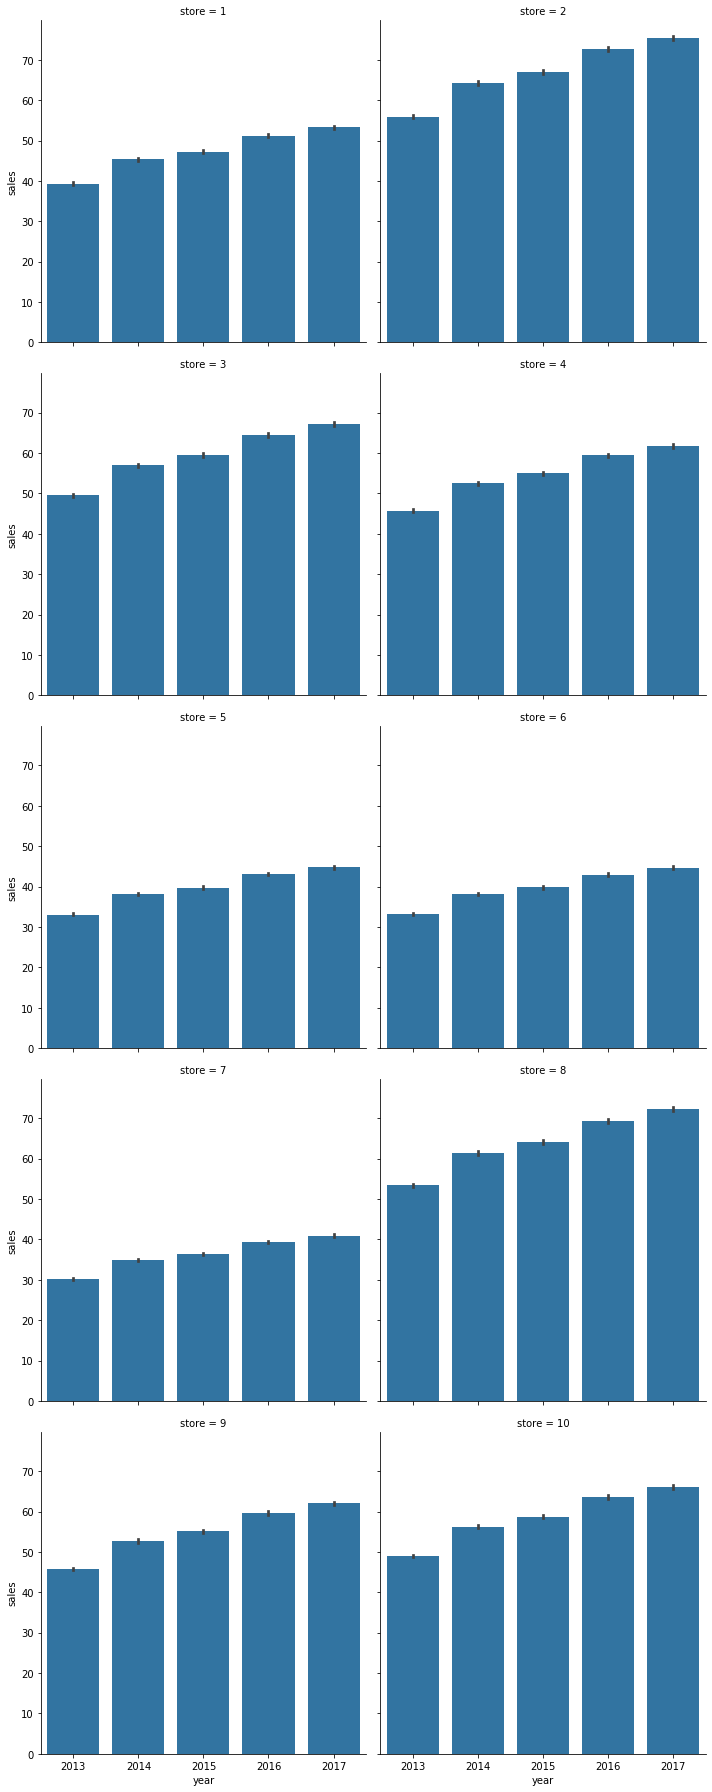

In [23]:
#let's plot the yearly sales for each store
g=sns.FacetGrid(df_SalesData,col="store", col_order=[1,2,3,4,5,6,7,8,9,10],col_wrap=2,height=5)
g.map(sns.barplot,"year","sales")

We see there is consistent increase in sales numbers every year at all the stores!


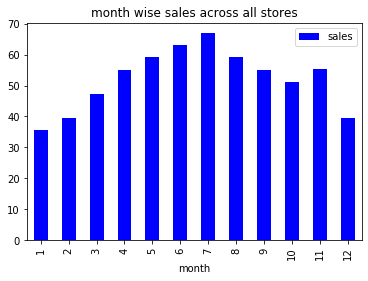

In [24]:
df_SalesData[['sales','month']].groupby(["month"]).mean().plot.bar(color='b', title='month wise sales across all stores')
plt.show()

Above plot shows there are higher sales in the month of June, July and August

2. Item

In [25]:
print_stats('item')

------------------------------------------------------------ 
 Individual Summary Statistics for item 
 ------------------------------------------------------------
Describe 
 count    913000.000000
mean         25.500000
std          14.430878
min           1.000000
25%          13.000000
50%          25.500000
75%          38.000000
max          50.000000
Name: item, dtype: float64 
 --------------------
Sample Observations 
 901920    50
53767      3
77842      5
451577    25
708915    39
Name: item, dtype: int64 
 --------------------
Number of Uniques 
 50 
 --------------------


Looks like there are 50 items. And we already saw there are 10 stores, so that gives us 500 time series in total.

In [99]:
print(sorted(df_SalesData.item.unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [26]:
#It looks like there are 50 items with values 1-50

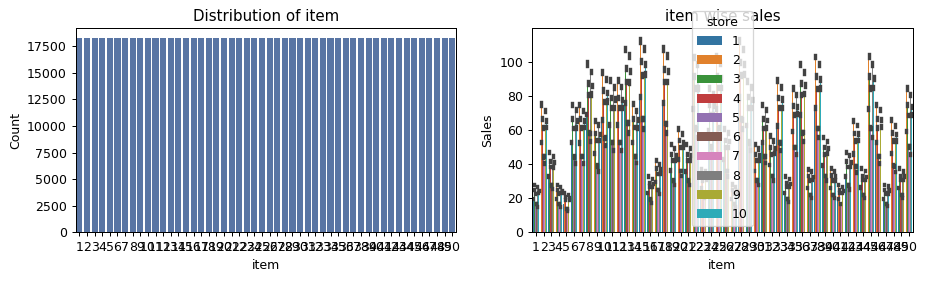

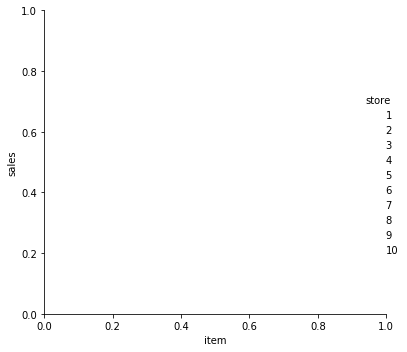

In [27]:
plot_var('item', 'item', False)

Store wise item sales Analysis
-----------------------------------


        date  store  item  sales  day  month  year  dayofweek
0 2013-01-01      1     1     13    1      1  2013          1
1 2013-01-02      1     1     11    2      1  2013          2
2 2013-01-03      1     1     14    3      1  2013          3
3 2013-01-04      1     1     13    4      1  2013          4
4 2013-01-05      1     1     10    5      1  2013          5
Top 5 selling items in store 1
------------------------------ 

          sales
item           
15    79.680723
28    79.566813
18    76.345564
13    76.159365
38    73.344469

 Bottom 5 selling items in store 1
------------------------------ 

          sales
item           
41    20.002738
1     19.971522
4     19.956188
47    19.814348
5     16.612815


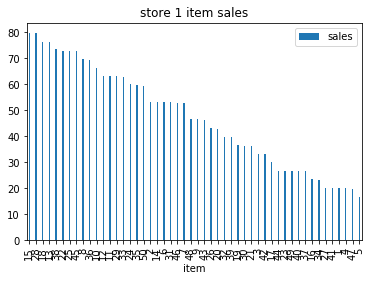

In [28]:
#Store 1:
store_analysis(1)

           date  store  item  sales  day  month  year  dayofweek
1826 2013-01-01      2     1     12    1      1  2013          1
1827 2013-01-02      2     1     16    2      1  2013          2
1828 2013-01-03      2     1     16    3      1  2013          3
1829 2013-01-04      2     1     20    4      1  2013          4
1830 2013-01-05      2     1     16    5      1  2013          5
Top 5 selling items in store 2
------------------------------ 

           sales
item            
28    112.638007
15    112.578861
18    108.117196
13    107.903067
25    103.426068

 Bottom 5 selling items in store 2
------------------------------ 

          sales
item           
4     28.234940
47    28.187842
1     28.173604
41    28.069551
5     23.540526


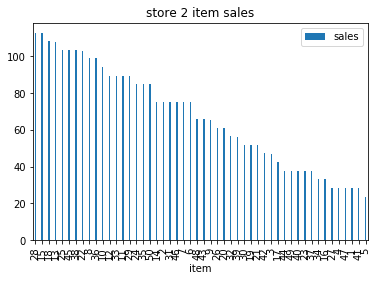

In [29]:
#Store 2:
store_analysis(2)


           date  store  item  sales  day  month  year  dayofweek
3652 2013-01-01      3     1     19    1      1  2013          1
3653 2013-01-02      3     1      8    2      1  2013          2
3654 2013-01-03      3     1     10    3      1  2013          3
3655 2013-01-04      3     1     15    4      1  2013          4
3656 2013-01-05      3     1     22    5      1  2013          5
Top 5 selling items in store 3
------------------------------ 

           sales
item            
15    100.423330
28    100.143483
13     96.214677
18     96.090909
38     91.871851

 Bottom 5 selling items in store 3
------------------------------ 

          sales
item           
4     25.116101
27    25.090909
1     25.070099
41    24.989047
5     20.857612


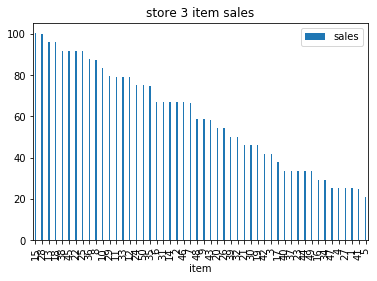

In [30]:
#Store 3:
store_analysis(3)


Interesting pattern emerging so far is the most and least sold items are more or less same for these all stores.
Let's see if the pattern continues for the restr of the stores

           date  store  item  sales  day  month  year  dayofweek
5478 2013-01-01      4     1     10    1      1  2013          1
5479 2013-01-02      4     1     12    2      1  2013          2
5480 2013-01-03      4     1      8    3      1  2013          3
5481 2013-01-04      4     1     15    4      1  2013          4
5482 2013-01-05      4     1     19    5      1  2013          5
Top 5 selling items in store 4
------------------------------ 

          sales
item           
15    92.653888
28    92.552574
13    88.604600
18    88.501643
25    85.022453

 Bottom 5 selling items in store 4
------------------------------ 

          sales
item           
47    23.114458
27    23.111720
4     23.086528
1     22.938664
5     19.525192


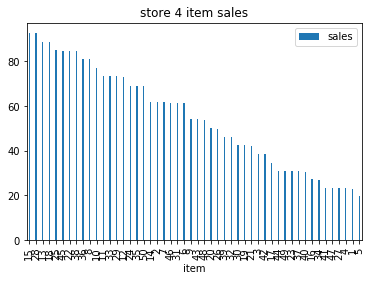

In [31]:
#Store 4:
store_analysis(4)

           date  store  item  sales  day  month  year  dayofweek
7304 2013-01-01      5     1     11    1      1  2013          1
7305 2013-01-02      5     1      9    2      1  2013          2
7306 2013-01-03      5     1     12    3      1  2013          3
7307 2013-01-04      5     1      8    4      1  2013          4
7308 2013-01-05      5     1     13    5      1  2013          5
Top 5 selling items in store 5
------------------------------ 

          sales
item           
15    66.987404
28    66.980832
13    64.395947
18    64.080504
45    61.427163

 Bottom 5 selling items in store 5
------------------------------ 

          sales
item           
4     16.776561
27    16.763417
1     16.739321
47    16.699343
5     14.086528


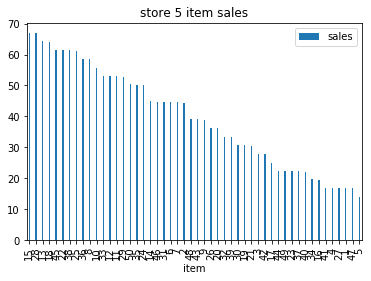

In [32]:
#Store 5:
store_analysis(5)

           date  store  item  sales  day  month  year  dayofweek
9130 2013-01-01      6     1     20    1      1  2013          1
9131 2013-01-02      6     1      6    2      1  2013          2
9132 2013-01-03      6     1     11    3      1  2013          3
9133 2013-01-04      6     1      7    4      1  2013          4
9134 2013-01-05      6     1     12    5      1  2013          5
Top 5 selling items in store 6
------------------------------ 

          sales
item           
15    66.668675
28    66.460570
13    64.324754
18    63.725630
25    61.364184

 Bottom 5 selling items in store 6
------------------------------ 

          sales
item           
4     16.754107
1     16.717963
47    16.708653
41    16.607338
5     13.893209


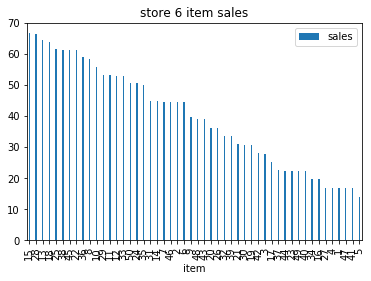

In [33]:
#Store 6:
store_analysis(6)

            date  store  item  sales  day  month  year  dayofweek
10956 2013-01-01      7     1      7    1      1  2013          1
10957 2013-01-02      7     1      4    2      1  2013          2
10958 2013-01-03      7     1      8    3      1  2013          3
10959 2013-01-04      7     1      7    4      1  2013          4
10960 2013-01-05      7     1      8    5      1  2013          5
Top 5 selling items in store 7
------------------------------ 

          sales
item           
15    61.139102
28    61.104053
18    58.745893
13    58.547645
25    56.398686

 Bottom 5 selling items in store 7
------------------------------ 

          sales
item           
41    15.471522
4     15.358160
27    15.213582
1     15.159365
5     12.733844


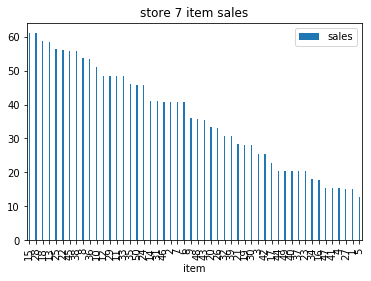

In [34]:
#Store 7:
store_analysis(7)

            date  store  item  sales  day  month  year  dayofweek
12782 2013-01-01      8     1     16    1      1  2013          1
12783 2013-01-02      8     1     10    2      1  2013          2
12784 2013-01-03      8     1     12    3      1  2013          3
12785 2013-01-04      8     1     21    4      1  2013          4
12786 2013-01-05      8     1     15    5      1  2013          5
Top 5 selling items in store 8
------------------------------ 

           sales
item            
15    108.047645
28    107.813253
18    103.820372
13    103.819825
25     99.244797

 Bottom 5 selling items in store 8
------------------------------ 

          sales
item           
27    27.044359
41    27.036145
1     26.983571
4     26.948521
5     22.427711


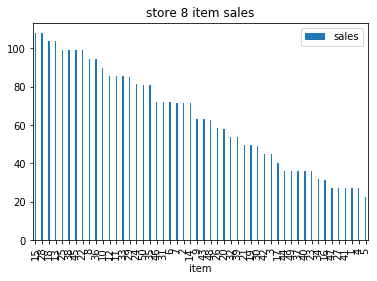

In [35]:
#Store 8:
store_analysis(8)

            date  store  item  sales  day  month  year  dayofweek
14608 2013-01-01      9     1     11    1      1  2013          1
14609 2013-01-02      9     1      9    2      1  2013          2
14610 2013-01-03      9     1     20    3      1  2013          3
14611 2013-01-04      9     1     22    4      1  2013          4
14612 2013-01-05      9     1     22    5      1  2013          5
Top 5 selling items in store 9
------------------------------ 

          sales
item           
15    93.137459
28    92.787514
18    88.610624
13    88.511501
25    85.136911

 Bottom 5 selling items in store 9
------------------------------ 

          sales
item           
1     23.325849
41    23.191128
4     23.150055
47    23.003286
5     19.272180


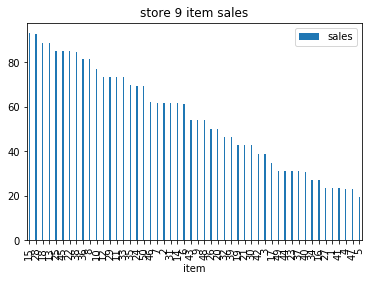

In [36]:
#Store 9:
store_analysis(9)

            date  store  item  sales  day  month  year  dayofweek
16434 2013-01-01     10     1     14    1      1  2013          1
16435 2013-01-02     10     1     14    2      1  2013          2
16436 2013-01-03     10     1     16    3      1  2013          3
16437 2013-01-04     10     1     17    4      1  2013          4
16438 2013-01-05     10     1     12    5      1  2013          5
Top 5 selling items in store 10
------------------------------ 

          sales
item           
15    98.990690
28    98.766156
18    94.719606
13    94.684556
45    90.690581

 Bottom 5 selling items in store 10
------------------------------ 

          sales
item           
1     24.736035
4     24.721249
27    24.701533
41    24.654984
5     20.637459


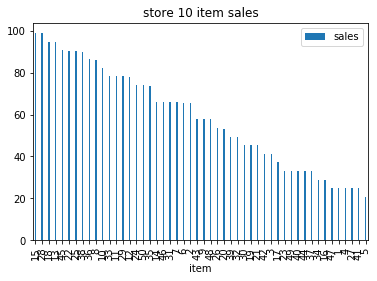

In [37]:
#Store 10:
store_analysis(10)

3. Date

In [28]:
df_SalesData.columns

Index(['date', 'store', 'item', 'sales', 'day', 'month', 'year', 'dayofweek'], dtype='object')

In [29]:
print_stats('date')

------------------------------------------------------------ 
 Individual Summary Statistics for date 
 ------------------------------------------------------------
Describe 
 count                  913000
unique                   1826
top       2017-07-04 00:00:00
freq                      500
first     2013-01-01 00:00:00
last      2017-12-31 00:00:00
Name: date, dtype: object 
 --------------------
Sample Observations 
 807749   2014-10-20
831702   2015-05-23
894465   2017-04-01
837059   2015-01-22
488787   2016-05-30
Name: date, dtype: datetime64[ns] 
 --------------------
Number of Uniques 
 1826 
 --------------------


the dates are from Jan 1 2013 to Dec 31 2017
The dates are for 5 years period.

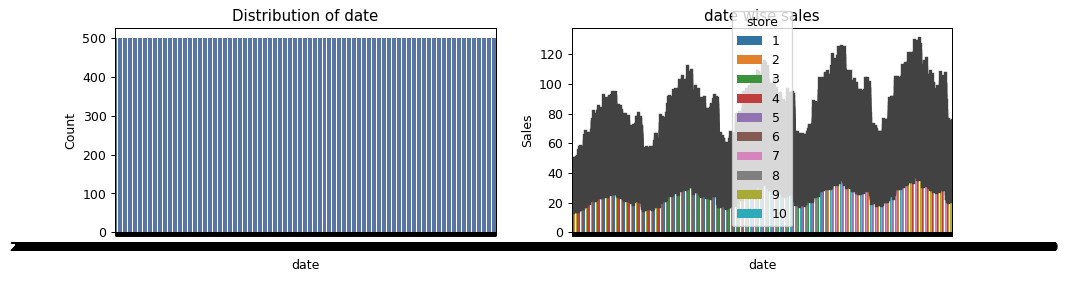

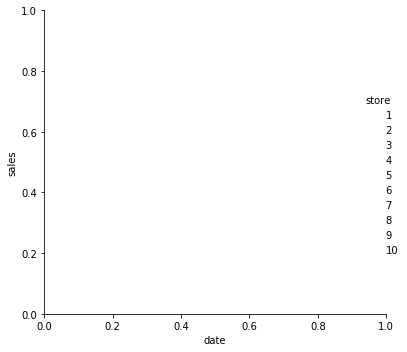

In [55]:
plot_var('date', 'date', False)

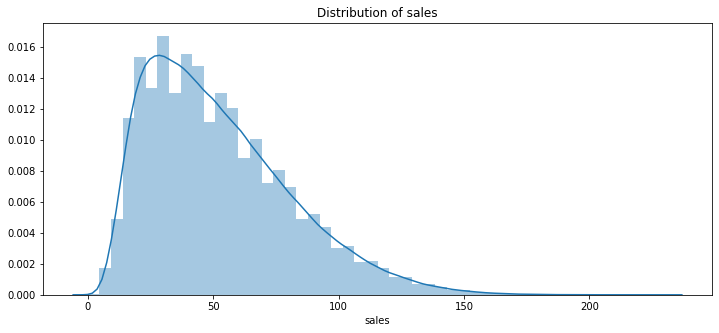

In [38]:
#Let's look at our target variable - sales and its distribution
plt.figure(figsize=(12,5))
plt.title("Distribution of sales")
ax = sns.distplot(df_SalesData['sales'])

In [60]:
print_stats('sales')

------------------------------------------------------------ 
 Individual Summary Statistics for sales 
 ------------------------------------------------------------
Describe 
 count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64 
 --------------------
Sample Observations 
 489573    30
103878    64
902745    32
20976     83
292799    44
Name: sales, dtype: int64 
 --------------------
Number of Uniques 
 213 
 --------------------


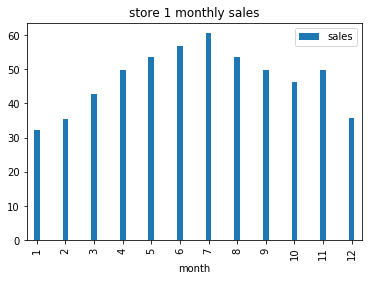

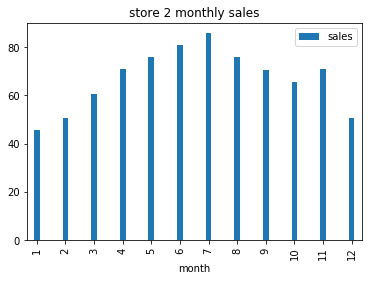

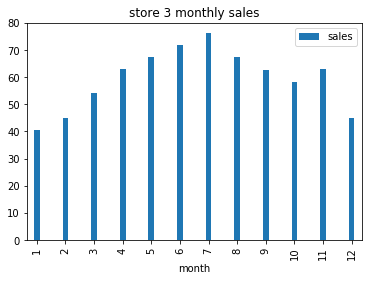

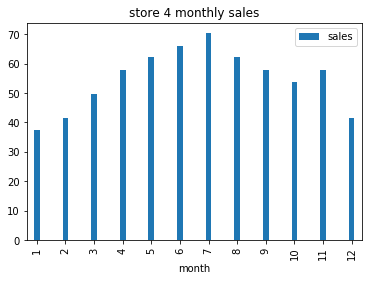

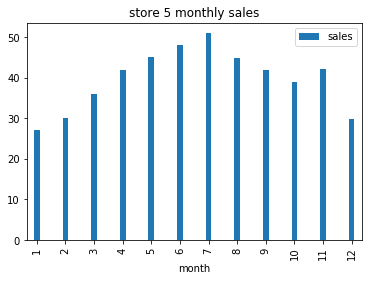

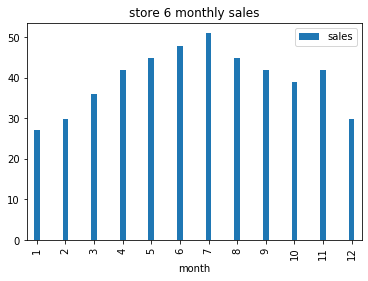

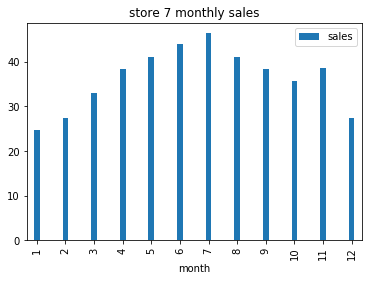

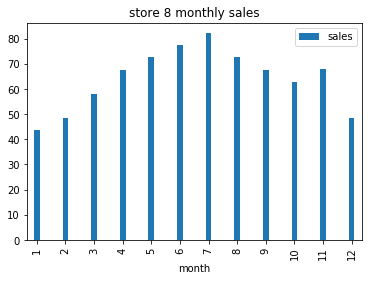

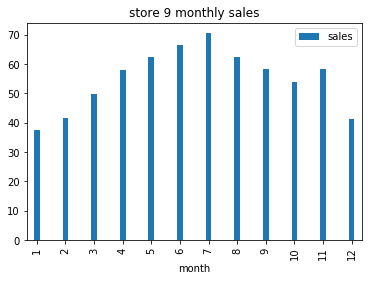

In [39]:
#let's plot monthly sales for each store, 
#that way we could comapre and see if the sales trends are similar across stores
monthly_sales(1)

Seasonality:
--------------
Let's plot the sales to look at the seasonality for-
-Yearly
-monthly
-weekly

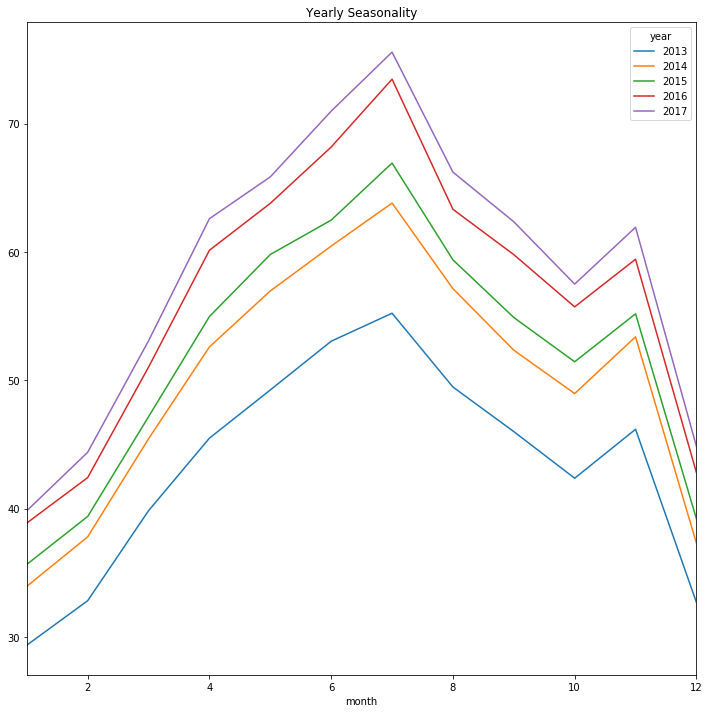

In [37]:
pivoted = pd.pivot_table(df_SalesData, values='sales', columns='year', index='month')
pivoted.plot(figsize=(12,12), title='Yearly Seasonality');

In [ ]:
From the above plot we can easily observe that-

-the sales go up year to year from 2013 to 2017 
- there is steady upward trend.
- there is also a monthly seasonality where sales are going up around middle of the year 

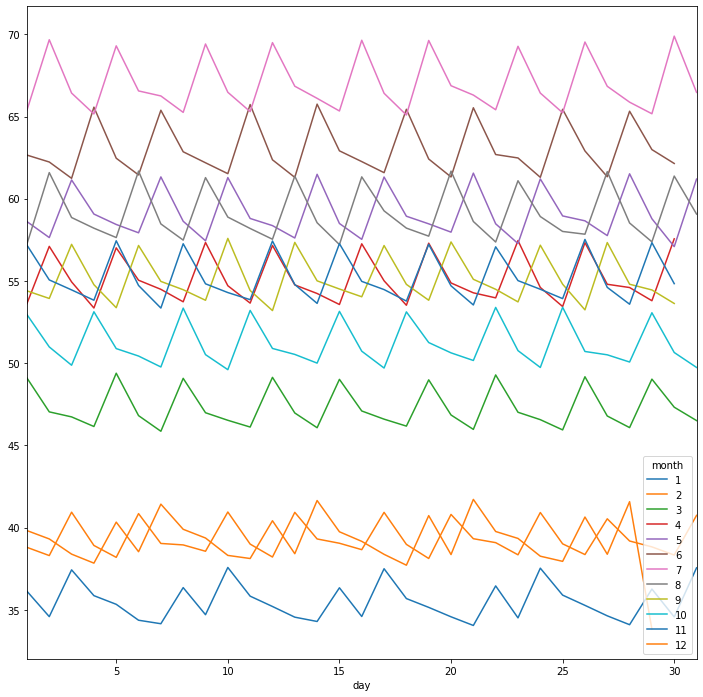

In [30]:
pivoted = pd.pivot_table(df_SalesData, values='sales', columns='month', index='day')
pivoted.plot(figsize=(12,12), title='Monthly Seasonality');

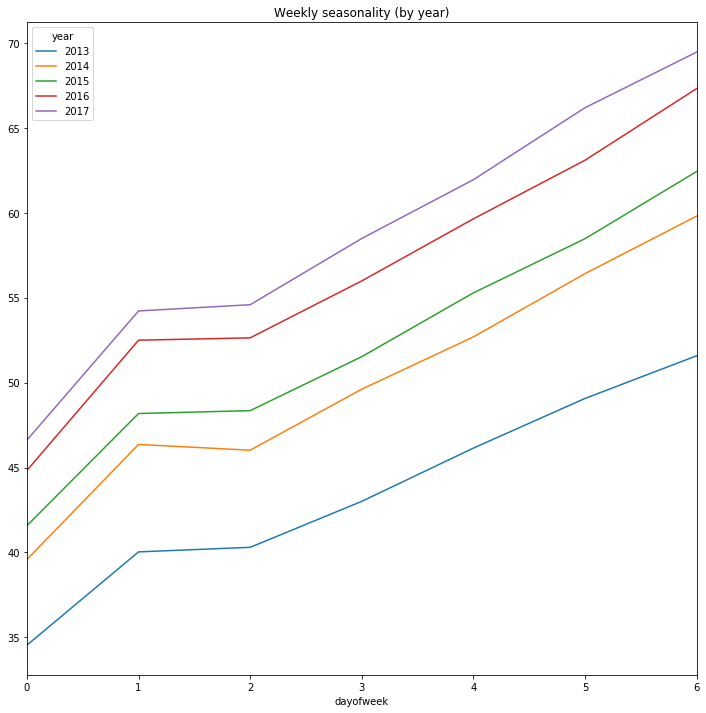

In [38]:
pivoted = pd.pivot_table(df_SalesData, values='sales', columns='year', index='dayofweek')
pivoted.plot(figsize=(12,12), title='Weekly seasonality (by year)');

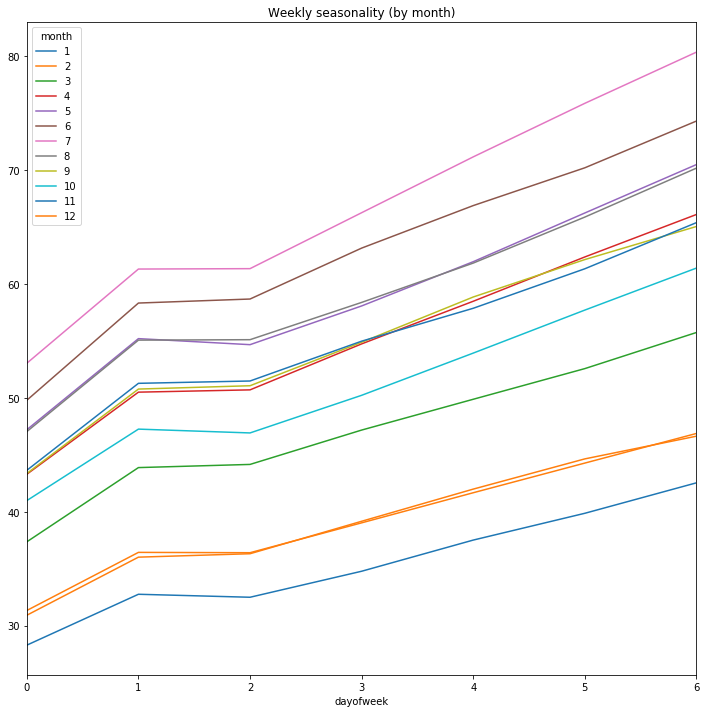

In [39]:
pivoted = pd.pivot_table(df_SalesData, values='sales', columns='month', index='dayofweek')
pivoted.plot(figsize=(12,12), title='Weekly seasonality (by month)');

This shows the sales follow the same trend year after year where sales peak up at the middle of the year and taper off with one exception in the month of November. Over the years the sales have gone up basically from year to year but follows the same trend.

In [30]:
df_SalesData.head()

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5


In [49]:
df_StoreSales=df_SalesData.loc[df_SalesData['store'] == 1]

In [50]:
df_StoreSales.index = df_StoreSales.date

In [52]:
#df_StoreSales.drop('date', inplace=True, axis=1)
#decomp_plot(df_StoreSales)

Baseline Model - Naive Approach
------------------

Naive method assumes that the next expected point is equal to the last observed point. This approach uses the value of last day sales and uses it to estimate sales for next day. So we have y ^ @t+1 = y @t


                 date  store  item  sales  day  month  year  dayofweek
date                                                                  
2017-12-26 2017-12-26      1    35     51   26     12  2017          1
2017-12-27 2017-12-27      1    35     54   27     12  2017          2
2017-12-28 2017-12-28      1    35     50   28     12  2017          3
2017-12-29 2017-12-29      1    35     48   29     12  2017          4
2017-12-30 2017-12-30      1    35     66   30     12  2017          5
                 date  store  item  sales  day  month  year  dayofweek
date                                                                  
2017-12-31 2017-12-31      1    35     55   31     12  2017          6
2013-01-01 2013-01-01      1    36     49    1      1  2013          1
2013-01-02 2013-01-02      1    36     48    2      1  2013          2
2013-01-03 2013-01-03      1    36     45    3      1  2013          3
2013-01-04 2013-01-04      1    36     41    4      1  2013          4


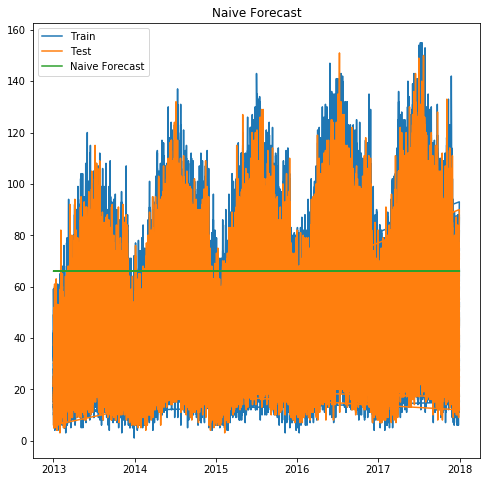


 RMSE for Naive Forecast = 32.62181194733771


In [36]:
naive_forecast(df_StoreSales, 'date', 'sales', 0.7)

In [56]:
test.shape

(27391, 8)

In [79]:
test.head(10)

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,36,49,1,1,2013,1
2013-01-02,1,36,48,2,1,2013,2
2013-01-03,1,36,45,3,1,2013,3
2013-01-04,1,36,41,4,1,2013,4
2013-01-05,1,36,48,5,1,2013,5
2013-01-06,1,36,47,6,1,2013,6
2013-01-07,1,36,27,7,1,2013,0
2013-01-08,1,36,29,8,1,2013,1
2013-01-09,1,36,39,9,1,2013,2


In [80]:
train.tail(10)

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2017-12-22,10,35,59,22,12,2017,4
2017-12-23,10,35,75,23,12,2017,5
2017-12-24,10,35,68,24,12,2017,6
2017-12-25,10,35,50,25,12,2017,0
2017-12-26,10,35,61,26,12,2017,1
2017-12-27,10,35,56,27,12,2017,2
2017-12-28,10,35,55,28,12,2017,3
2017-12-29,10,35,65,29,12,2017,4
2017-12-30,10,35,55,30,12,2017,5


In [60]:
df_SalesData.columns

Index(['date', 'store', 'item', 'sales', 'day', 'month', 'year', 'dayofweek'], dtype='object')

In [57]:
df_SalesData.columns = ['ds', 'store', 'item', 'y', 'day', 'month', 'year', 'dayofweek']

In [58]:
df_SalesData.columns

Index(['ds', 'store', 'item', 'y', 'day', 'month', 'year', 'dayofweek'], dtype='object')

In [59]:
df_SalesData.shape

(913000, 8)

In [60]:
df_store=df_SalesData.loc[df_SalesData['store'] == 1]
df_store.shape

(91300, 8)

Prophet Baseline
--------------------
We will build the model using Facebook Prophet package. It allows specifying multiple seasonalities and special events and allows making predictions.


In [67]:
#Baseline Prophet
#Model Fitting
#%%time
#prModel = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
prModel = Prophet()
prModel.fit(df_store[['ds','y']])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [68]:
#predicting
future = prModel.make_future_dataframe(periods=90)
future.tail()

,ds
91385,2018-03-27
91386,2018-03-28
91387,2018-03-29
91388,2018-03-30
91389,2018-03-31


In [69]:
forecast = prModel.predict(future)

In [70]:
forecast.shape

(91390, 19)

In [71]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,40.773134,-4.249546,48.797871,40.773134,40.773134,-17.204528,-17.204528,-17.204528,-3.676853,-3.676853,-3.676853,-13.527675,-13.527675,-13.527675,0.0,0.0,0.0,23.568606
1,2013-01-01,40.773134,-2.340070,50.186151,40.773134,40.773134,-17.204528,-17.204528,-17.204528,-3.676853,-3.676853,-3.676853,-13.527675,-13.527675,-13.527675,0.0,0.0,0.0,23.568606
2,2013-01-01,40.773134,-4.456505,50.715591,40.773134,40.773134,-17.204528,-17.204528,-17.204528,-3.676853,-3.676853,-3.676853,-13.527675,-13.527675,-13.527675,0.0,0.0,0.0,23.568606
3,2013-01-01,40.773134,-2.115061,48.682420,40.773134,40.773134,-17.204528,-17.204528,-17.204528,-3.676853,-3.676853,-3.676853,-13.527675,-13.527675,-13.527675,0.0,0.0,0.0,23.568606
4,2013-01-01,40.773134,-3.398321,49.108843,40.773134,40.773134,-17.204528,-17.204528,-17.204528,-3.676853,-3.676853,-3.676853,-13.527675,-13.527675,-13.527675,0.0,0.0,0.0,23.568606


In [72]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
91385,2018-03-27,49.936831,22.257920,78.190689
91386,2018-03-28,50.457440,24.228759,77.176179
91387,2018-03-29,53.601694,28.115534,82.264035
91388,2018-03-30,56.972782,30.131663,83.623312
91389,2018-03-31,60.529908,35.079880,85.601203


In [73]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,23.568606,-4.249546,48.797871
1,2013-01-01,23.568606,-2.340070,50.186151
2,2013-01-01,23.568606,-4.456505,50.715591
3,2013-01-01,23.568606,-2.115061,48.682420
4,2013-01-01,23.568606,-3.398321,49.108843


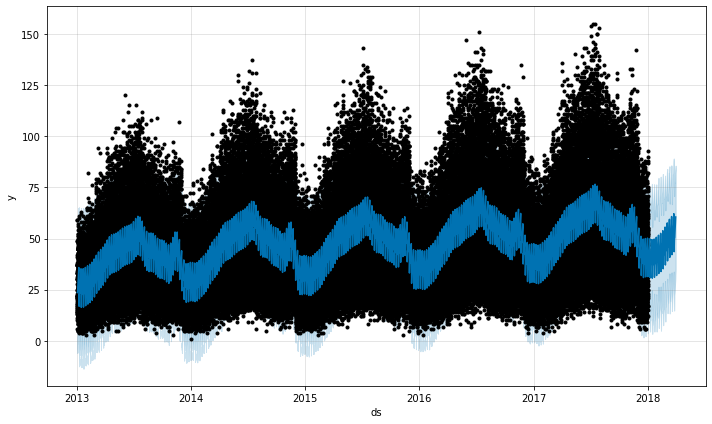

In [74]:
#The blue line in the graph represents the predicted values while the black dots represents the data in our dataset.
plot1 = prModel.plot(forecast)

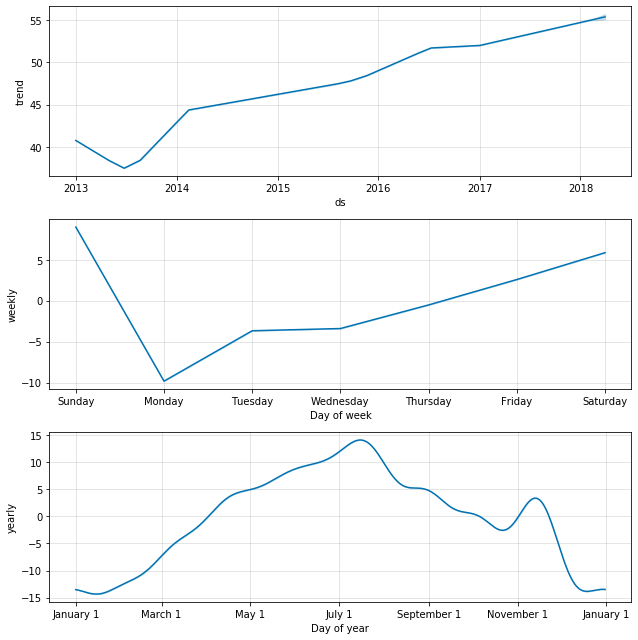

In [75]:
#Plot individual componenets of forecast
#The plot_components method plots the trend, yearly and weekly seasonality of the time series data.
plot2 = prModel.plot_components(forecast)

Results Analysis
-------------------
-Looking at the yearly plot, it looks like the shopping sales go higher in the month of July. And start tapering off till the end of the month with an exception of month of November. This might be due to the "black Friday' sales happening in Nov. So understandably the sales pick up in that month.
-Also if we look at the weekely plot, there is a peak in sales on Saturday and Sunday
-The first plot 'trend' shows consistent data as observed in our analysis that the sales have picked up year after year with a steady growth.


Model Improvements
-------------------------
-For the reasons outlined above and looking the sales trend for 'Black Fridays' and over the weekends, we will see if adding holidays feature in prophet will improve the performance of the model or not.
We will now add seasonalities like yearly, monthly and daily. In addition we will also add the holidays to better improve the performance.

In [76]:
#Defining special events - superbowl and playoffs

playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19'
                       ]),
  'lower_window': 0,
  'upper_window': 3,
})

holidays = pd.concat((playoffs, superbowls))

In [77]:
holiModel = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
holiModel.fit(df_store[['ds','y']]);

In [78]:
future_holi = holiModel.make_future_dataframe(periods=90)
future_holi.tail(n=3)

,ds
91387,2018-03-29
91388,2018-03-30
91389,2018-03-31


In [79]:
forecast_holi = holiModel.predict(future_holi)
forecast_holi.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,playoff,playoff_lower,playoff_upper,superbowl,superbowl_lower,superbowl_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
91387,2018-03-29,33.215754,26.488469,81.974007,32.905112,33.526771,20.484217,20.484217,20.484217,22.13734,22.13734,22.13734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.478711,-0.478711,-0.478711,-1.174413,-1.174413,-1.174413,0.0,0.0,0.0,53.699972
91388,2018-03-30,33.223298,30.339650,82.869853,32.906339,33.546595,23.806829,23.806829,23.806829,22.13734,22.13734,22.13734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.582197,2.582197,2.582197,-0.912708,-0.912708,-0.912708,0.0,0.0,0.0,57.030128
91389,2018-03-31,33.230842,31.276059,89.119894,32.911176,33.558905,27.351981,27.351981,27.351981,22.13734,22.13734,22.13734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.857233,5.857233,5.857233,-0.642592,-0.642592,-0.642592,0.0,0.0,0.0,60.582823


Cross Validation and Performance Metrics
-------------------------------------------------
SOme of the metrics for regression performance are - Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R Squared (R²),Adjusted R Squared (R²),Mean Squared Percentage Error (MSPE),Mean Absolute Percentage Error (MAPE)
While MSE deals with absolute errors, MPSE and MAPE work with relative errors.It can also be thought of as weighted versions of MAE. MAPE is considered to be popular measure of forecast accuracy.

MAPE gives very high eror for near-zero item, thus highly affecting the overall error rate when it is averaged in. For forecasts of items that are near or at zero volume, Symmetric Mean Absolute Percent Error (SMAPE) is a better measure.
So we will start of by using RMSE and then move to be using SMAPE. Symmetric Mean Absolute Percent Error (SMAPE) is an alternative to Mean Absolute Percent Error (MAPE) when there are zero or near-zero demand for items. SMAPE self-limits to an error rate of 200%, reducing the influence of these low volume items. Low volume items are problematic because they could otherwise have infinitely high error rates that skew the overall error rate.
SMAPE is the forecast minus actuals divided by the sum of forecasts and actuals as expressed in this formula:



1. horizon: the forecast horizon
2. initial: the size of the initial training period
3. period: the spacing between cutoff dates
The output of the cross_validation method is a dataframe containing y the true values and yhat the predicted values. We’ll use this dataframe to compute the prediction errors.

In [80]:
df_cv = cross_validation(prModel, initial = '730 days', period = '45 days', horizon = '90 days')
df_cv.head()

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-10-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-17,38.803527,13.531444,62.718586,45,2015-01-16
1,2015-01-17,38.803527,14.831965,63.631547,62,2015-01-16
2,2015-01-17,38.803527,15.606726,62.940238,44,2015-01-16
3,2015-01-17,38.803527,14.096251,62.759499,36,2015-01-16
4,2015-01-17,38.803527,14.144230,62.583210,29,2015-01-16


#
yhat : the predicted forecast
yhat_lower : the lower border of the prediction
yhat_upper: the upper border of the prediction
cutoff: how far into the future the prediction was

In [81]:
df_performance = performance_metrics(df_cv)
df_performance.head()

,horizon,mse,rmse,mae,mape,coverage
0,9 days,512.308386,22.634230,19.069804,0.529604,0.703575
1,10 days,512.489157,22.638223,19.052899,0.532338,0.701159
2,11 days,512.863904,22.646499,19.026799,0.531087,0.702126
3,12 days,514.781980,22.688807,19.038949,0.531030,0.701546
4,13 days,510.499411,22.594234,18.972636,0.529255,0.702802


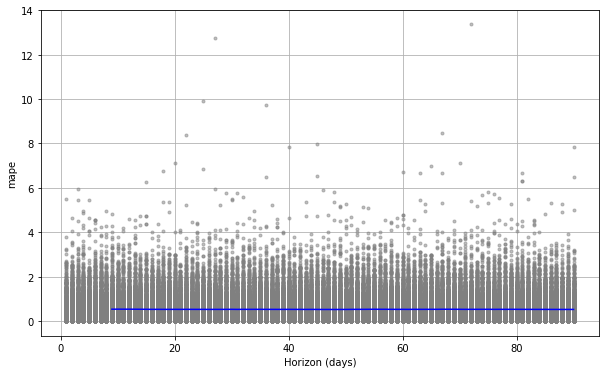

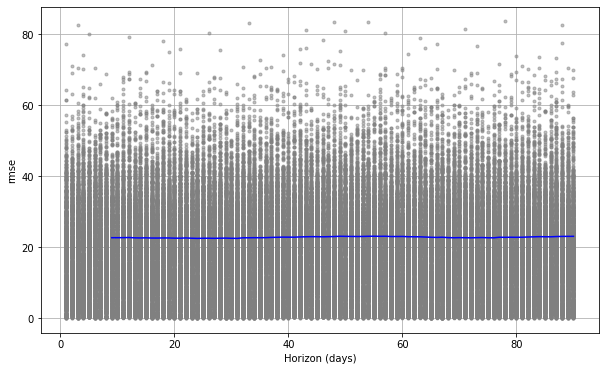

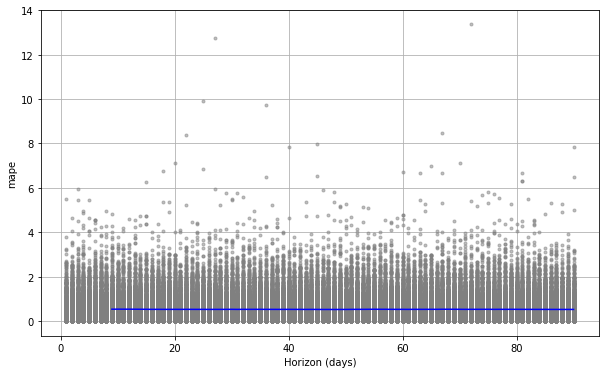

In [85]:
#Visualizing Performance Metrics
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric = 'rmse')
plot_cross_validation_metric(df_cv, metric = 'mape')